In [1]:
# importacion de librerias

import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#Set de datos:

In [2]:
tick = "ETH-USD"

In [3]:
fecha_hoy = pd.Timestamp.today().strftime('%Y-%m-%d')

In [4]:
df = yf.download(tick, start="2015-01-01", end=fecha_hoy)

[*********************100%***********************]  1 of 1 completed


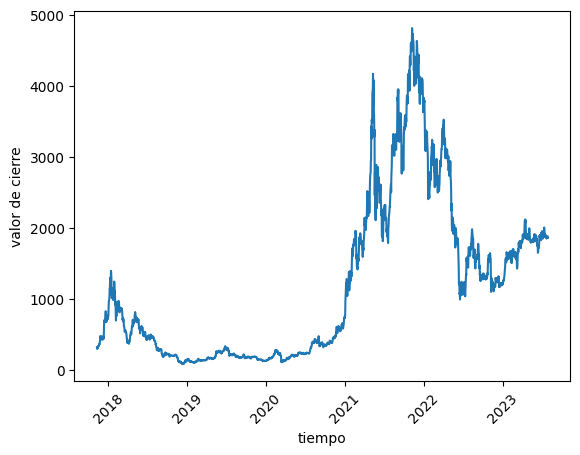

In [5]:
#grafica de como el valor de close va subiendo o bajando, basicamente el valor de la accion
plt.xlabel("tiempo")
plt.ylabel("valor de cierre")
plt.plot(df['Close'])
plt.xticks(rotation = 45)
plt.show()

In [6]:
#obtengo la diferencia de open y close
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low # tambien la de high y low que es mayor y menor precio de la accion en ese dia

X = df[['Open-Close','High-Low']] #de lo anterior obtengo mis datos de input
X.head()

,Open-Close,High-Low
Date,,
2017-11-09,-12.239014,22.395996
2017-11-10,21.417999,30.175995
2017-11-11,-16.095001,21.261017
2017-11-12,6.782013,20.640015
2017-11-13,-9.691010,21.390015


In [7]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,0)
type(y)

numpy.ndarray

In [8]:
#divido los datos X y "y" en entrenamiento y test
split_percentage = 0.8
split = int(split_percentage * len(df))

X_train = X[:split]
y_train = y[:split]

X_test = X[split:]
y_test = y[split:]

In [9]:
len(X), len(y)

(2090, 2090)

#Preparacion de datos para el modelo

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Datos de entrada
data = X_train  # Tu secuencia de datos
target =  y_train# La secuencia objetivo que deseas predecir

# Crear el generador de series de tiempo
length = 10  # Tamaño de cada secuencia
batch_size = 32  # Tamaño del lote

generator = TimeseriesGenerator(data, target, length=length, batch_size=batch_size)



#Construccion de la red CONVOLUCIONAL

In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Crear el modelo convolucional
model = Sequential()
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(length, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Entrenar el modelo utilizando el generador de datos
model.fit(generator, epochs=50, steps_per_epoch=len(generator))




Epoch 1/50
52/52 [==============================] - 14s 6ms/step - loss: 0.4182 - accuracy: 0.4928
Epoch 2/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3855 - accuracy: 0.5259
Epoch 3/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3735 - accuracy: 0.5211
Epoch 4/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3636 - accuracy: 0.5277
Epoch 5/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3756 - accuracy: 0.5265
Epoch 6/50
52/52 [==============================] - 0s 4ms/step - loss: 0.3600 - accuracy: 0.5301
Epoch 7/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3788 - accuracy: 0.5385
Epoch 8/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3757 - accuracy: 0.5313
Epoch 9/50
52/52 [==============================] - 0s 5ms/step - loss: 0.3614 - accuracy: 0.5415
Epoch 10/50
52/52 [==============================] - 0s 4ms/step - loss: 0.3429 - accuracy: 0.5686
Epoch 11/50
52/52 

#Prueba del Modelo (Recall)

In [12]:
# ajustar dimensiones de los datos de prueba
data = X_test  # Tu secuencia de datos
target =  y_test # La secuencia para comparar

# Crear el generador de series de tiempo
length = 10  # Tamaño de cada secuencia
batch_size = 32  # Tamaño del lote

generator_test = TimeseriesGenerator(data, np.zeros(len(data)), length=length, batch_size=batch_size)

In [13]:
#relizar las predicciones:
# Realiza las predicciones utilizando el generador
predictions = model.predict(generator_test)


13/13 [==============================] - 0s 5ms/step


In [14]:
predicciones_array = np.squeeze(predictions)

In [15]:
umbral = 0.5
predicciones_binarias = (predicciones_array >= umbral).astype(int)

In [16]:
filas_perdidas = len(X_test)-len(predicciones_binarias) #se calcula cuantos datos quedaron sin usar

In [17]:
y_recall = y_test[filas_perdidas:] # se toman los datos de y_test desde el dato que se toman las predicciones.

In [18]:
len(y_recall), len(predicciones_binarias)

(408, 408)

In [19]:
import numpy as np
from sklearn.metrics import recall_score

# Calcula el recall
recall = recall_score(y_recall, predicciones_binarias)

print("Recall:", recall)

Recall: 0.5641025641025641


#Realizar la grafica comparativa

In [20]:
# Calculate daily returns
df['Return'] = df.Close.pct_change() #funcion para sacar el porcentaje de aumento o disminucion
df['Return']

Date
2017-11-09         NaN
2017-11-10   -0.067411
2017-11-11    0.051555
2017-11-12   -0.021523
2017-11-13    0.028606
                ...   
2023-07-26    0.007761
2023-07-27   -0.006304
2023-07-28    0.007734
2023-07-29    0.003373
2023-07-30   -0.010327
Name: Return, Length: 2090, dtype: float64

In [26]:
#calcular las predicciones(ahora para toda la variable y):

#preparar los datos

# ajustar dimensiones de los datos de prueba
data = X  # Tu secuencia de datos
target =  y # La secuencia para comparar

# Crear el generador de series de tiempo
length = 10  # Tamaño de cada secuencia
batch_size = 32  # Tamaño del lote

generator_final = TimeseriesGenerator(data, np.zeros(len(data)), length=length, batch_size=batch_size)

predicciones = model.predict(generator_final) #predicciones

predicciones_array = np.squeeze(predicciones) #hacerlas un aaray de una dimension

umbral = 0.5
predicciones_binarias = (predicciones_array >= umbral).astype(int) #pasar segun la probabilidad a 1 o 0

datos_perdidos = len(y) - len(predicciones_binarias) #calcular los datos que no se usaron

df = df[datos_perdidos:] #reajustar el dataframe

65/65 [==============================] - 0s 3ms/step


In [22]:
len(predicciones_binarias), len(df)

(2080, 2080)

In [23]:
df['Predicted_Signal'] = predicciones_binarias #adjunto las predicciones realizadas al dataframe
df['Predicted_Signal']

<ipython-input-23-7dabae667d25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted_Signal'] = predicciones_binarias #adjunto las predicciones realizadas al dataframe


Date
2017-11-19    1
2017-11-20    0
2017-11-21    0
2017-11-22    1
2017-11-23    0
             ..
2023-07-26    0
2023-07-27    1
2023-07-28    1
2023-07-29    0
2023-07-30    1
Name: Predicted_Signal, Length: 2080, dtype: int64

In [24]:
# Calculate strategy returns
df['Strategy_Return'] = df.Return *df.Predicted_Signal.shift(1)

# Calculate Cumulutive returns
df['Cum_Ret'] = df['Return'].cumsum()

# Plot Strategy Cumulative returns
df['Cum_Strategy'] = df['Strategy_Return'].cumsum()

<ipython-input-24-94c313da0062>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Strategy_Return'] = df.Return *df.Predicted_Signal.shift(1)
<ipython-input-24-94c313da0062>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cum_Ret'] = df['Return'].cumsum()
<ipython-input-24-94c313da0062>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(array([17167., 17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

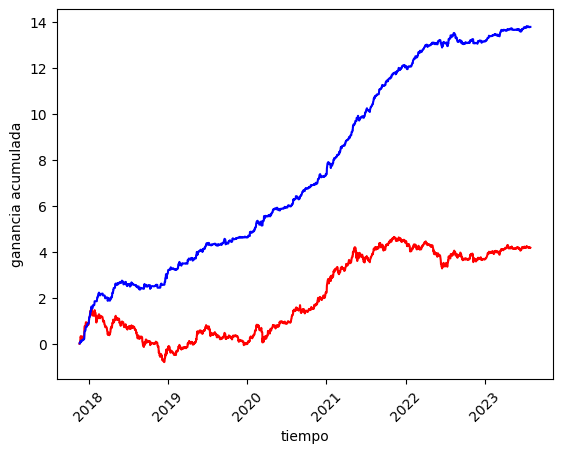

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("tiempo")
plt.ylabel("ganancia acumulada")

plt.plot(df['Cum_Ret'],color='red')
plt.plot(df['Cum_Strategy'],color='blue')
plt.xticks(rotation = 45)